# Dataset & Libraries

In [ ]:
# import of libraries we will use
#!pip install fastdtw
%matplotlib inline
import random
from math import sqrt, log, floor
from fastdtw import fastdtw
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import euclidean
import scipy.cluster.hierarchy
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.metrics import mean_squared_error

sns.set(style='white')
# "fix" the randomness for reproducibility
random.seed(42)

In [27]:
# load data
data = pd.read_csv('./train.txt', header=None, delim_whitespace=True)
# data normalization
for column in range(2, 26):
    data[column] = (data[column] - data[column].mean()) / data[column].std()
data.shape

(45918, 26)

In [29]:
df_filtered = data[data.iloc[:,1] == 1]
df_filtered.head()
data.tail(n=5)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
45913,218,129,1.216582,0.864324,-0.282197,-1.052966,-0.764267,-0.514436,-0.487150,-1.135852,...,-0.982410,0.414281,-0.031529,0.179251,-0.710463,-0.549398,-0.112171,0.419839,-1.030607,-1.038006
45914,218,130,1.216332,0.869148,-0.282197,-1.052966,-0.789674,-0.511801,-0.530813,-1.135852,...,-0.982193,0.413424,-0.041180,0.172202,-0.710463,-0.585320,-0.112171,0.419839,-1.047773,-1.042112
45915,218,131,1.216129,0.864324,-0.282197,-1.052966,-0.793686,-0.571451,-0.464398,-1.135852,...,-0.984943,0.413814,-0.033177,0.199868,-0.710463,-0.513475,-0.112171,0.419839,-1.050802,-1.054953
45916,218,132,0.743008,0.870435,0.333118,-0.885167,-0.616371,-0.375378,-0.503377,-0.703003,...,-0.607347,0.415604,-0.262921,0.118068,-0.710463,-0.405707,-0.036670,0.419839,-0.613591,-0.637868
45917,218,133,0.067476,0.161926,0.948434,-0.390083,-1.126921,-1.367033,-1.145112,-0.270153,...,-0.736542,-2.386076,-2.428188,2.184481,-0.710463,-1.375618,-2.150692,-2.381813,-0.665087,-0.665485


In [ ]:
data[0].shape

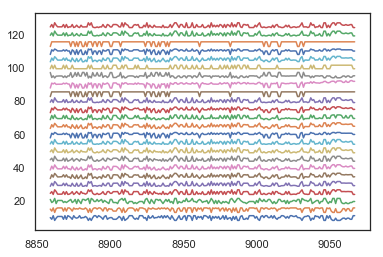

In [30]:
serie = data[data[0]==43]
for i in range(2, 26):
    (serie[i]+5*i).plot(x=1)

In [ ]:
# group data by each timeserie
grouped = data.groupby(0)
series = [group.drop(labels=[0,1], axis=1) for name, group in grouped]
# number of clusters
k = 6
# length of chunks
chunk_length = 10
# go through groups and compute chunks and labels
train_set = []
true_labels = []
for serie in series:
    reversed_serie = serie.iloc[::-1]
    for i in range(len(serie) // chunk_length):        
        chunk = reversed_serie[i*10:(i+1)*10]
        true_label = i
        train_set.append(chunk)
        true_labels.append(true_label)

In [26]:
# sampling
n = 4400
indices = random.sample(list(range(len(train_set))), k=n) 
sample = [train_set[i] for i in indices]
sample_labels = [true_labels[i] for i in indices]

ValueError: Sample larger than population or is negative

In [ ]:
from datetime import datetime
startTime = datetime.now()

# compute eucledean distance
euclidean_distances = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        euclidean_distances[i,j] = euclidean(sample[i].values.flatten(),
                                             sample[j].values.flatten())
        
print(datetime.now() - startTime)        

In [ ]:
import pickle

with open('rmse.pickle', 'wb') as f:
    pickle.dump(rmse_distances, f)

In [ ]:
startTime = datetime.now()
# compute distances using RMSE
rmse_distances = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        rmse_distances[i,j] = sqrt(mean_squared_error(sample[i].values.flatten(),
                                                      sample[j].values.flatten()))

print(datetime.now() - startTime) 

In [ ]:
# compute distances using DTW
from datetime import datetime
startTime = datetime.now()
def dtw(x, y):
    dist, _ = fastdtw(x, y, dist=euclidean,n_jobs=-1)
    return dist

dtw_distances = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        dtw_distances[i,j] = dtw(sample[i], sample[j])
 
print(datetime.now() - startTime) 

In [ ]:
import pickle

with open('dtw_distances.pickle', 'wb') as f:
    pickle.dump(dtw_distances, f)

In [ ]:
from datetime import datetime
startTime = datetime.now()

# compute distances using LCSS

# function for LCSS computation
# based on implementation from
# https://rosettacode.org/wiki/Longest_common_subsequence
def lcs(a, b):  
    lengths = [[0 for j in range(len(b)+1)] for i in range(len(a)+1)]
    # row 0 and column 0 are initialized to 0 already
    for i, x in enumerate(a):
        for j, y in enumerate(b):
            if x == y:
                lengths[i+1][j+1] = lengths[i][j] + 1
            else:
                lengths[i+1][j+1] = max(lengths[i+1][j], lengths[i][j+1])
    x, y = len(a), len(b)
    result = lengths[x][y]
    return result

def discretise(x):
    return int(x * 10)

def multidim_lcs(a, b):
    a = a.applymap(discretise)
    b = b.applymap(discretise)
    rows, dims = a.shape
    lcss = [lcs(a[i+2], b[i+2]) for i in range(dims)]
    return 1 - sum(lcss) / (rows * dims)

lcs_distances = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        lcs_distances[i,j] = multidim_lcs(sample[i], sample[j])     
        
print(datetime.now() - startTime)         

In [ ]:
import pickle
d1 = open('eluc.pickle', 'rb') 
d2 = open('rmse.pickle', 'rb') 
d3 = open('dtw_distances.pickle', 'rb') 
euclidean_distances = pickle.load(d1)
rmse_distances = pickle.load(d2)
dtw_distances = pickle.load(d3)

k = 6
y_pred_km_euc = KMeans(n_clusters=k).fit_predict(euclidean_distances)
y_pred_km_rmse = KMeans(n_clusters=k).fit_predict(rmse_distances)
y_pred_km_dtw = KMeans(n_clusters=k).fit_predict(dtw_distances)
#y_pred_km_lcs = KMeans(n_clusters=k).fit_predict(lcs_distances)

y_pred_hac_rmse = AgglomerativeClustering(n_clusters=k).fit_predict(rmse_distances)
y_pred_hac_euc = AgglomerativeClustering(n_clusters=k)\
                 .fit_predict(euclidean_distances)
y_pred_hac_dtw = AgglomerativeClustering(n_clusters=k).fit_predict(dtw_distances)
#y_pred_hac_lcs = AgglomerativeClustering(n_clusters=k).fit_predict(lcs_distances)

# True label normalisation
log_base = max(true_labels)**(1 / k) + 0.05
normalised_true_labels = [floor(log(l+1, log_base)) for l in sample_labels]

In [ ]:
print('Normalized Mutual Information')
print('K-means + Eucledean: ', normalized_mutual_info_score(normalised_true_labels,
                                                            y_pred_km_euc))
print('K-means + RMS:       ', normalized_mutual_info_score(normalised_true_labels,
                                                            y_pred_km_rmse))
print('K-means + DTW:       ', normalized_mutual_info_score(normalised_true_labels,
                                                            y_pred_km_dtw))
#print('K-means + LCSS:      ', normalized_mutual_info_score(normalised_true_labels,
#                                                            y_pred_km_dtw))
print('HAC + Eucledean:     ', normalized_mutual_info_score(normalised_true_labels,
                                                            y_pred_hac_euc))
print('HAC + RMS:           ', normalized_mutual_info_score(normalised_true_labels,
                                                            y_pred_hac_rmse))
print('HAC + DTW:           ', normalized_mutual_info_score(normalised_true_labels,
                                                            y_pred_hac_dtw))
#print('HAC + LCSS:          ', normalized_mutual_info_score(normalised_true_labels,
#                                                            y_pred_hac_dtw))

In [ ]:
print('Adjusted Rand Index')
print('K-means + Eucledean:  ', adjusted_rand_score(normalised_true_labels,
                                                    y_pred_km_euc))
print('K-means + RMS:       ', adjusted_rand_score(normalised_true_labels,
                                                   y_pred_km_rmse))
print('K-means + DTW:       ', adjusted_rand_score(normalised_true_labels,
                                                   y_pred_km_dtw))
#print('K-means + LCSS:       ', adjusted_rand_score(normalised_true_labels,
#                                                    y_pred_km_dtw))
print('HAC + Eucledean:     ', adjusted_rand_score(normalised_true_labels,
                                                   y_pred_hac_euc))
print('HAC + RMS:           ', adjusted_rand_score(normalised_true_labels,
                                                   y_pred_hac_rmse))
print('HAC + DTW:           ', adjusted_rand_score(normalised_true_labels,
                                                   y_pred_hac_dtw))
#print('HAC + LCSS:           ', adjusted_rand_score(normalised_true_labels,
#                                                    y_pred_hac_dtw))

In [20]:
# computeting features for a single chunk and sensor
def extract_featrues(chunk, s):
    column = chunk[s]
    slope = (column.iloc[-1]-column.iloc[0])/10
    return (column.std(), column.mean(), slope)

def compute_features_for_all_chunks(s):
    stds = []
    means = []
    slopes = []

    for chunk in sample:
        std, mean, slope = extract_featrues(chunk, s)
        stds.append(std)
        means.append(mean)
        slopes.append(slope)
    return pd.DataFrame({'std': stds, 'mean': means, 'slope': slopes,
                         'true_label': normalised_true_labels,
                         'cluster': y_pred_hac_dtw})

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3

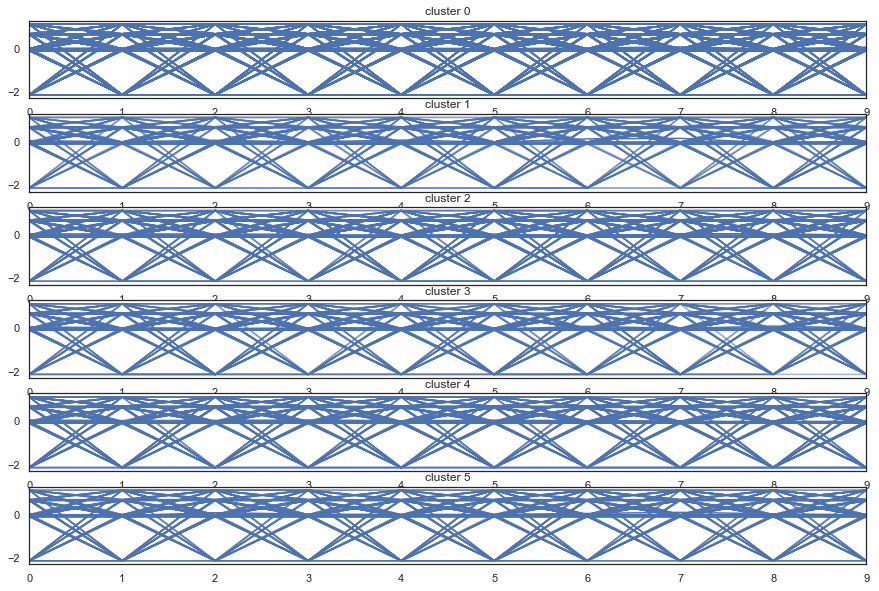

In [25]:

num_cluster =6
#len(set(y_pred_hac_dtw))
sensor = 22

f, axis = plt.subplots(num_cluster, 1, figsize=(15, 10))
for c in range(num_cluster):
    index = y_pred_hac_dtw == c
    cluster_chunks = pd.DataFrame([chunk[sensor].reset_index(drop=True) 
                                   for chunk, flag in zip(sample, index)
                                   if flag]).as_matrix()
    sns.tsplot(data=cluster_chunks, err_style='unit_traces', ax=axis[c])
    axis[c].set_title('cluster ' + str(c))